# Assignment 1 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: Ferrara Luigi
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

In [1]:
import os
import pandas as pd
import torch 
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torchvision
from torchvision import transforms
import kagglehub
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, balanced_accuracy_score
# add additonal imports here
class FashionDataset(Dataset):
    def __init__(self, csv_file, img_dir,column_class="articleTypeId", transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with labels.
            img_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)  # load CSV file
        self.img_dir = img_dir  # image folder path
        self.transform = transform  # image transformations
        self.targets = list(self.df[column_class].values)


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.df.loc[idx,'imageId']}.jpg")  # Get image filename
        image = Image.open(img_name).convert("RGB")  # Load image

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, self.targets[idx]

Download data with kagglehub

In [2]:
dataset_path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
img_dir = os.path.join(dataset_path,"images")

The different datasets can be loaded using the class `FashionDataset` which is a custon PyTorch dataset (see [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information). Below an example of how to use the `FashionDataset` constructor as well as some visualizations. Please note that you may have to adapt the arguments to match the strucucture of your working directory.

In [3]:
dataset = FashionDataset("dataset/train.csv",img_dir)

In [4]:
dataset.df.head()

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0
2,9464,Shirts,Topwear,1,0
3,8194,Shirts,Topwear,1,0
4,42231,Tops,Topwear,6,0


<class 'PIL.Image.Image'>


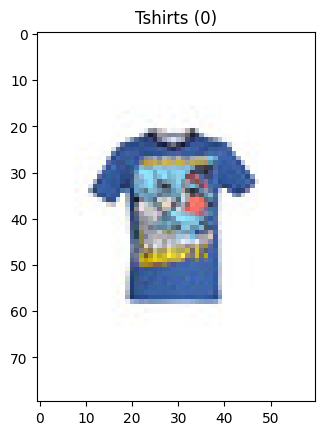

<class 'PIL.Image.Image'>


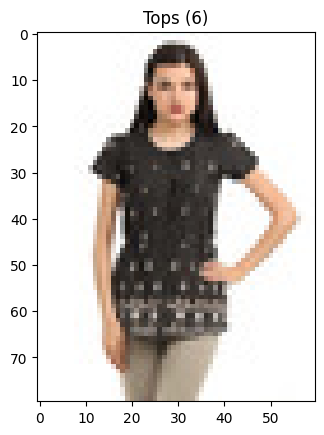

<class 'PIL.Image.Image'>


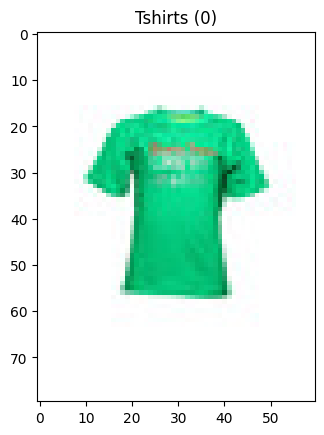

In [5]:
np.random.seed(42)
random_indices = np.random.choice(len(dataset),3)

for i in random_indices:
    img, label = dataset[i]
    print(type(img))
    plt.title(dataset.df.iloc[i]["articleTypeName"]+f" ({label.item()})")
    plt.imshow(img)
    plt.show()

## Loading different datasets

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for ResNet
    transforms.ToTensor(),          # Convert PIL Image to Tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize for RGB images
    # your image transformations 
]) 
train_dataset = FashionDataset("dataset/train.csv",img_dir,transform=transform)
main_test_dataset =  FashionDataset("dataset/main_test.csv",img_dir,transform=transform)
new_test_dataset =  FashionDataset("dataset/new_test.csv",img_dir,transform=transform)
main_support_dataset =  FashionDataset("dataset/main_support.csv",img_dir,transform=transform)
new_support_dataset =  FashionDataset("dataset/new_support.csv",img_dir,transform=transform)
merged_test_dataset =  FashionDataset("dataset/merged_test.csv",img_dir,transform=transform) # merged corresponds to main+new
merged_support_dataset =  FashionDataset("dataset/merged_support.csv",img_dir,transform=transform)

# datasets with categories
main_test_dataset_cat =  FashionDataset("dataset/main_test.csv",img_dir,column_class="categoryId",transform=transform)
main_support_dataset_cat =  FashionDataset("dataset/main_support.csv",img_dir,column_class="categoryId",transform=transform)

label_id_to_label_name = {i: train_dataset.df[train_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39)} 
label_id_to_label_name.update({i: new_test_dataset.df[new_test_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39,39+30)})

# Task 1

In [ ]:
# your solution
# train dataset: train_dataset
# test datset: main_test_dataset

train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dl = DataLoader(main_test_dataset, batch_size=64, shuffle=True)

model = torchvision.models.resnet18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 39)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    
    model.train()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    bal_acc = balanced_accuracy_score(all_labels, all_preds)

    print(f"Epoch [{epoch+1}/5], Loss: {running_loss/len(train_dl):.4f}, Accuracy: {acc:.4f}, Balanced Accuracy: {bal_acc:.4f}")

In [13]:
# Evaluation phase on test set
model.eval()
test_preds = []
test_labels = []
test_loss = 0.0
with torch.no_grad():  # Disable gradient computation for test set
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
# Calculate test accuracy and balanced accuracy
test_acc = accuracy_score(test_labels, test_preds)
test_bal_acc = balanced_accuracy_score(test_labels, test_preds)
# Print statistics
print(f"Test Loss: {test_loss/len(test_dl):.4f}, Test Accuracy: {test_acc:.4f}, "
      f"Test Balanced Accuracy: {test_bal_acc:.4f}")

Test Loss: 0.4095, Test Accuracy: 0.8773, Test Balanced Accuracy: 0.8266


### Try a new data loader


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust colors
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),  # Normalize
])
train_dataset = FashionDataset("dataset/train.csv",img_dir,transform=transform)
main_test_dataset =  FashionDataset("dataset/main_test.csv",img_dir,transform=transform)
new_test_dataset =  FashionDataset("dataset/new_test.csv",img_dir,transform=transform)
main_support_dataset =  FashionDataset("dataset/main_support.csv",img_dir,transform=transform)
new_support_dataset =  FashionDataset("dataset/new_support.csv",img_dir,transform=transform)
merged_test_dataset =  FashionDataset("dataset/merged_test.csv",img_dir,transform=transform) # merged corresponds to main+new
merged_support_dataset =  FashionDataset("dataset/merged_support.csv",img_dir,transform=transform)

# datasets with categories
main_test_dataset_cat =  FashionDataset("dataset/main_test.csv",img_dir,column_class="categoryId",transform=transform)
main_support_dataset_cat =  FashionDataset("dataset/main_support.csv",img_dir,column_class="categoryId",transform=transform)

label_id_to_label_name = {i: train_dataset.df[train_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39)} 
label_id_to_label_name.update({i: new_test_dataset.df[new_test_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39,39+30)})

In [23]:
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dl = DataLoader(main_test_dataset, batch_size=64, shuffle=True)

model = torchvision.models.resnet18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 39)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    
    model.train()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    bal_acc = balanced_accuracy_score(all_labels, all_preds)

    print(f"Epoch [{epoch+1}/10], Loss: {running_loss/len(train_dl):.4f}, Accuracy: {acc:.4f}, Balanced Accuracy: {bal_acc:.4f}")

Epoch [1/10], Loss: 0.9605, Accuracy: 0.6993, Balanced Accuracy: 0.5708
Epoch [2/10], Loss: 0.5305, Accuracy: 0.8208, Balanced Accuracy: 0.7394
Epoch [3/10], Loss: 0.4286, Accuracy: 0.8521, Balanced Accuracy: 0.7870
Epoch [4/10], Loss: 0.3611, Accuracy: 0.8724, Balanced Accuracy: 0.8186
Epoch [5/10], Loss: 0.3121, Accuracy: 0.8904, Balanced Accuracy: 0.8451
Epoch [6/10], Loss: 0.2745, Accuracy: 0.9018, Balanced Accuracy: 0.8628
Epoch [7/10], Loss: 0.2292, Accuracy: 0.9161, Balanced Accuracy: 0.8838
Epoch [8/10], Loss: 0.1930, Accuracy: 0.9294, Balanced Accuracy: 0.9041
Epoch [9/10], Loss: 0.1509, Accuracy: 0.9458, Balanced Accuracy: 0.9270
Epoch [10/10], Loss: 0.1267, Accuracy: 0.9534, Balanced Accuracy: 0.9360


In [24]:
# Evaluation phase on test set
model.eval()
test_preds = []
test_labels = []
test_loss = 0.0
with torch.no_grad():  # Disable gradient computation for test set
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
# Calculate test accuracy and balanced accuracy
test_acc = accuracy_score(test_labels, test_preds)
test_bal_acc = balanced_accuracy_score(test_labels, test_preds)
# Print statistics
print(f"Test Loss: {test_loss/len(test_dl):.4f}, Test Accuracy: {test_acc:.4f}, "
      f"Test Balanced Accuracy: {test_bal_acc:.4f}")

Test Loss: 0.4039, Test Accuracy: 0.8768, Test Balanced Accuracy: 0.8291


## Task 2

In [7]:
import os
import pandas as pd
import torch 
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms
import kagglehub
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from itertools import combinations
import tqdm
from tqdm import tqdm
from torch.utils.data.sampler import BatchSampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [8]:
# your solution
# train dataset: train_dataset
# test and support dataset: see scenarios table
class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """
    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [164]:
train_dataset_sampler = BalancedBatchSampler(train_dataset.targets, n_classes=39, n_samples=3)
main_test_dataset_sampler = BalancedBatchSampler(main_test_dataset.targets, n_classes=39, n_samples=3)
new_test_dataset_sampler = BalancedBatchSampler(new_test_dataset.targets, n_classes=30, n_samples=3)
main_support_dataset_sampler = BalancedBatchSampler(main_support_dataset.targets, n_classes=39, n_samples=3)
new_support_dataset_sampler = BalancedBatchSampler(new_support_dataset.targets, n_classes=30, n_samples=3)
merged_test_dataset_sampler = BalancedBatchSampler(merged_test_dataset.targets, n_classes=69, n_samples=3)
merged_support_dataset_sampler = BalancedBatchSampler(merged_support_dataset.targets, n_classes=69, n_samples=3)

test_cat_dataset_sampler = BalancedBatchSampler(main_test_dataset_cat.targets, n_classes=20, n_samples=3)
support_cat_dataset_sampler = BalancedBatchSampler(main_support_dataset_cat.targets, n_classes=20, n_samples=3)

triplets_train_dataset = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_dataset_sampler)
triplets_main_test_dataset = torch.utils.data.DataLoader(main_test_dataset, batch_sampler=main_test_dataset_sampler)
triplets_new_test_dataset = torch.utils.data.DataLoader(new_test_dataset, batch_sampler=new_test_dataset_sampler)
triplets_main_support_dataset = torch.utils.data.DataLoader(main_support_dataset, batch_sampler=main_support_dataset_sampler)
triplets_new_support_dataset = torch.utils.data.DataLoader(new_support_dataset, batch_sampler=new_support_dataset_sampler)
triplets_merged_test_dataset = torch.utils.data.DataLoader(merged_test_dataset, batch_sampler=merged_test_dataset_sampler)
triplets_merged_support_dataset = torch.utils.data.DataLoader(merged_support_dataset, batch_sampler=merged_support_dataset_sampler)

triplets_test_cat_dataset = torch.utils.data.DataLoader(main_test_dataset_cat, batch_sampler=test_cat_dataset_sampler)
triplets_supp_cat_dataset = torch.utils.data.DataLoader(main_support_dataset_cat, batch_sampler=support_cat_dataset_sampler)


triplets_train_dataset = torch.utils.data.DataLoader(train_dataset, batch_size=39*3)
triplets_main_test_dataset = torch.utils.data.DataLoader(main_test_dataset, batch_size=39*3)
triplets_new_test_dataset = torch.utils.data.DataLoader(new_test_dataset, batch_size=30*3)
triplets_main_support_dataset = torch.utils.data.DataLoader(main_support_dataset, batch_size=39*3)
triplets_new_support_dataset = torch.utils.data.DataLoader(new_support_dataset, batch_size=30*3)
triplets_merged_test_dataset = torch.utils.data.DataLoader(merged_test_dataset, batch_size=69*3)
triplets_merged_support_dataset = torch.utils.data.DataLoader(merged_support_dataset, batch_size=69*3)

triplets_test_cat_dataset = torch.utils.data.DataLoader(main_test_dataset_cat, batch_size=20*3)
triplets_supp_cat_dataset = torch.utils.data.DataLoader(main_support_dataset_cat, batch_size=20*3)

In [165]:
class RandomTripletSelector():
    """
    Select random negative  example for  each positive pair  to create triplets
    """
    def __init__(self):
        super(RandomTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            temp_triplets = [[anchor_positive[0], anchor_positive[1], np.random.choice(negative_indices)] for anchor_positive in anchor_positives]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))

class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """
    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):
        triplets = self.triplet_selector.get_triplets(embeddings, target)
        if embeddings.is_cuda:
            triplets = triplets.to(embeddings.device)

        anchor_idx= triplets[:, 0]
        positive_idx= triplets[:, 1]
        negative_idx= triplets[:, 2]

        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)
        return losses.mean()

class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.DataLoader,
                 validation_DataLoader: torch.utils.data.DataLoader ,
                 epochs: int
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs

    def run_trainer(self):
        for epoch in tqdm(range(self.epochs)):
            self.model.train() 
            train_losses=[]
            for batch in self.training_DataLoader:
                x,y=batch
                input, target = x.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()
                out = self.model(input)
                loss = self.criterion(out, target)

                loss_value = loss.item()
                #print(f"loss: {loss_value:.4f}", end=' ')
                train_losses.append(loss_value)

                loss.backward()
                self.optimizer.step()

            self.model.eval()
            valid_losses = []

            for batch in self.validation_DataLoader:
                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

                with torch.no_grad():
                    out = self.model(input)   # one forward pass
                    loss = self.criterion(out, target) # calculate loss
                    loss_value = loss.item()
                    valid_losses.append(loss_value)

            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

In [166]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 39)
model.to(device)
triplet_selector = RandomTripletSelector()
criterion = TripletLoss(margin=1.0, triplet_selector=triplet_selector)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

train_loader = triplets_train_dataset
val_loader   = triplets_main_support_dataset

num_epochs = 30
trainer = Trainer(
    model=model,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    training_DataLoader=train_loader,
    validation_DataLoader=val_loader,
    epochs=num_epochs
)

'Set True to train the net'
train_flag = False
if train_flag:
    trainer.run_trainer()

    # Save the embedding weights
    os.makedirs("checkpoints", exist_ok=True)
    torch.save(model.state_dict(), "checkpoints/embedding_net.pth")
    print("Training complete. Model saved to checkpoints/embedding_net.pth")

Using device: cuda


c:\Users\gabri\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gabri\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [167]:
# Run to load the checkpoints of the net
checkpoint = torch.load('checkpoints/embedding_net.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Testing the model on different scenarios

In [168]:
def extract_embeddings(model, dataloader):
    """
    Extract embeddings from the model for the given dataloader.
    Args:
        model (torch.nn.Module): The trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
    Returns:
        torch.Tensor: Concatenated embeddings from the model.
        torch.Tensor: Corresponding labels for the embeddings.
    """
    device = next(model.parameters()).device  
    embeddings = []
    labels = []
    image_ids = []
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.to(device)
            output = model(x)
            embeddings.append(output.cpu())
            labels.append(y.cpu())
            image_ids.append(dataloader.dataset.df.iloc[i]["imageId"])
    return torch.cat(embeddings), torch.cat(labels), image_ids

In [171]:
# scenario 1
embeddings1, labels1, img_ids1 = extract_embeddings(model, triplets_main_test_dataset)
embeddings2, labels2, img_ids2= extract_embeddings(model, triplets_train_dataset)

# scenario 2
embeddings3, labels3, img_ids3 = extract_embeddings(model, triplets_main_test_dataset)
embeddings4, labels4, img_ids4 = extract_embeddings(model, triplets_main_support_dataset)

# scenario 3
embeddings5, labels5, img_ids5 = extract_embeddings(model, triplets_new_test_dataset)
embeddings6, labels6, img_ids6 = extract_embeddings(model, triplets_new_support_dataset)

# scenario 4
embeddings7, labels7, img_ids7 = extract_embeddings(model, triplets_merged_test_dataset)
embeddings8, labels8, img_ids8 = extract_embeddings(model, triplets_merged_support_dataset)

In [172]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score

def evaluate_scenario(test_embeddings, test_labels, support_embeddings, support_labels):
    # Fit k-NN on the support set
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(support_embeddings, support_labels)

    # Predict on the test set
    preds = knn.predict(test_embeddings)

    # Compute accuracy
    acc = accuracy_score(test_labels, preds)
    bal_acc = balanced_accuracy_score(test_labels, preds)
    return acc, bal_acc

# Scenario 1: Main test set with main support set
acc1, bal_acc1 = evaluate_scenario(embeddings1, labels1, embeddings2, labels2)
print(f"Scenario 1 - Main Test Set with Main Support Set Accuracy: {acc1:.4f} and Balanced Accuracy: {bal_acc1:.4f}")

# Scenario 2: Main test set with new support set
acc2, bal_acc2 = evaluate_scenario(embeddings3, labels3, embeddings4, labels4)
print(f"Scenario 2 - Main Test Set with New Support Set Accuracy: {acc2:.4f} and Balanced Accuracy: {bal_acc2:.4f}")

# Scenario 3: New test set with new support set
acc3, bal_acc3 = evaluate_scenario(embeddings5, labels5, embeddings6, labels6)
print(f"Scenario 3 - New Test Set with New Support Set Accuracy: {acc3:.4f} and Balanced Accuracy: {bal_acc3:.4f}")

# Scenario 4: Merged test set with merged support set
acc4, bal_acc4 = evaluate_scenario(embeddings7, labels7, embeddings8, labels8)
print(f"Scenario 4 - Merged Test Set with Merged Support Set Accuracy: {acc4:.4f} and Balanced Accuracy: {bal_acc4:.4f}")


Scenario 1 - Main Test Set with Main Support Set Accuracy: 0.8247 and Balanced Accuracy: 0.7886
Scenario 2 - Main Test Set with New Support Set Accuracy: 0.7591 and Balanced Accuracy: 0.6804
Scenario 3 - New Test Set with New Support Set Accuracy: 0.7000 and Balanced Accuracy: 0.6896
Scenario 4 - Merged Test Set with Merged Support Set Accuracy: 0.6574 and Balanced Accuracy: 0.5967


# Task 3

In [ ]:
# your solution
# test dataset: merged_test_dataset
# support/catalog dataset: support_test_dataset

In [173]:
from scipy.spatial.distance import cdist

def average_precision(sorted_class_vals, true_class):
    # Convert to tensors if they're numpy arrays
    if isinstance(sorted_class_vals, np.ndarray):
        sorted_class_vals = torch.from_numpy(sorted_class_vals)
    if isinstance(true_class, np.ndarray):
        true_class = torch.tensor(true_class)
    
    ind = (sorted_class_vals == true_class).float()
    num_positive = ind.sum()
    if num_positive == 0:
        return 0.0
    cum_ind = torch.cumsum(ind, dim=0)
    enum = torch.arange(1, len(ind)+1, dtype=torch.float32)
    return torch.sum(cum_ind * ind / enum) / num_positive

# CHECK BETTER THIS PART
'lets say we use main classes support as a support dataset'
support_loader = triplets_merged_support_dataset
test_loader = triplets_merged_test_dataset
support_dataset = merged_support_dataset
test_dataset = merged_test_dataset
support_embeddings, support_labels, _ = extract_embeddings(model, support_loader)
test_embeddings, test_labels, _ = extract_embeddings(model, test_loader)

# Convert to numpy arrays if they're tensors
if isinstance(support_embeddings, torch.Tensor):
    support_embeddings = support_embeddings.numpy()
if isinstance(test_embeddings, torch.Tensor):
    test_embeddings = test_embeddings.numpy()
if isinstance(support_labels, torch.Tensor):
    support_labels = support_labels.numpy()
if isinstance(test_labels, torch.Tensor):
    test_labels = test_labels.numpy()

# Correction 1
distances=cdist(test_embeddings, support_embeddings)

In [162]:
# Run only one time; define classes for the next section
id2name = dict(zip(test_dataset.df.articleTypeId, test_dataset.df.articleTypeName))
max_id = max(id2name.keys())
classes = [id2name[i] for i in range(max_id+1)]

TypeError: 'numpy.float64' object is not callable

In [174]:
printing_stats = False
correct_predictions = 0
N = min(len(support_embeddings), len(test_embeddings))
max_ap = 0.0

for k in range(N):
    sorted_idx = list((np.argsort(distances[k,:])))
    sorted_idx = sorted_idx[1:]

    if ((test_labels[k] == support_labels[sorted_idx[0]]) or
        (test_labels[k] == support_labels[sorted_idx[1]]) or
        (test_labels[k] == support_labels[sorted_idx[2]])):
        correct_predictions += 1

    if printing_stats:
        print(correct_predictions)
        print("------------------------")
        print("True class:")
        print(classes[test_labels[k]])
        print("Top 3 predicted:")
        print([classes[support_labels[i]] for i in sorted_idx[:3]])
        print("Average precision {}".format(average_precision(support_labels[sorted_idx], test_labels[k])))
        print()

    if average_precision(support_labels[sorted_idx], test_labels[k]) > max_ap:
        max_ap = average_precision(support_labels[sorted_idx], test_labels[k])
    
print(max_ap)
print(correct_predictions/N)

tensor(1.)
0.7868673050615596


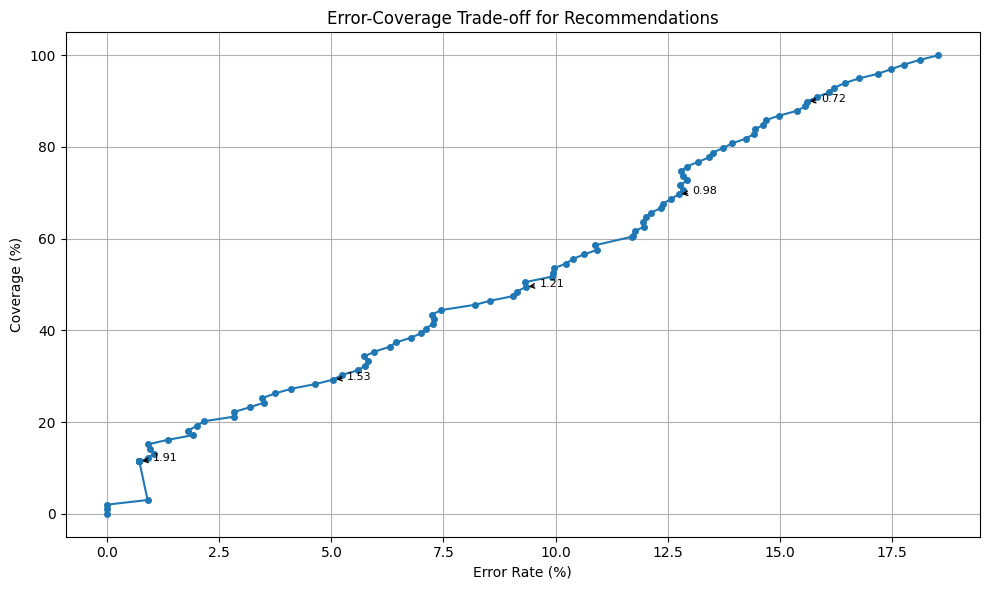

At 10.0% error rate, coverage is 53.5%


In [175]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

def dynamic_k_recommendations(distances, max_k=10, catalog_labels=None):
    if catalog_labels is None:
        raise ValueError("catalog_labels must be provided.")

    num_queries = distances.shape[0]
    recommendations = []
    confidence_scores = []

    for i in range(num_queries):
        query_distances = distances[i]
        best_confidence = -1
        best_k_indices = None

        for k in range(3, max_k + 1):
            top_k_indices = np.argsort(query_distances)[:k]
            top_k_dists = query_distances[top_k_indices]
            top_k_labels = catalog_labels[top_k_indices]

            # Confidence metrics
            # 1. Label frequency (reciprocal rank)
            label_weights = {}
            for rank, label in enumerate(top_k_labels):
                score = 1 / (rank + 1)
                label_weights[label] = label_weights.get(label, 0) + score

            probs = np.array(list(label_weights.values()))
            max_prob = np.max(probs)
            ent = entropy(probs)

            # 2. Label consistency
            _, counts = np.unique(top_k_labels, return_counts=True)
            topk_consistency = np.max(counts) / k

            # 3. Distance margin between top-2 label classes
            label_to_first_dist = {}
            for dist, label in zip(top_k_dists, top_k_labels):
                if label not in label_to_first_dist:
                    label_to_first_dist[label] = dist
            sorted_dists = sorted(label_to_first_dist.values())
            margin = (sorted_dists[1] - sorted_dists[0]) if len(sorted_dists) > 1 else 0
            norm_margin = margin / (np.mean(top_k_dists) + 1e-6)

            # Final confidence score (weighted sum)
            confidence = (
                0.4 * max_prob +
                0.2 * topk_consistency +
                0.15 * np.exp(-ent) +
                0.15 * norm_margin
            )

            if confidence > best_confidence:
                best_confidence = confidence
                best_k_indices = top_k_indices

        recommendations.append(best_k_indices[:3])
        confidence_scores.append(best_confidence)

    return np.array(recommendations), np.array(confidence_scores)

def evaluate_recommendations(recommendations, input_labels, catalog_labels):
    """
    A recommendation is correct if at least one of the top-3 matches the input label.
    """
    is_correct = []
    for i, rec_indices in enumerate(recommendations):
        predicted_labels = [catalog_labels[idx] for idx in rec_indices]
        is_correct.append(input_labels[i] in predicted_labels)
    return np.array(is_correct)

def calculate_error_coverage_curve(confidence_scores, correct_recommendations, num_thresholds=100):
    total = len(confidence_scores)
    percentiles = np.linspace(0, 100, num_thresholds)
    thresholds = np.percentile(confidence_scores, percentiles)

    error_rates = []
    coverage_rates = []

    for thresh in thresholds:
        selected = confidence_scores >= thresh
        coverage = np.sum(selected) / total * 100

        if np.sum(selected) > 0:
            error_rate = 100 * (1 - np.mean(correct_recommendations[selected]))
        else:
            error_rate = 0

        coverage_rates.append(coverage)
        error_rates.append(error_rate)

    return thresholds, error_rates, coverage_rates

# -------------------------
# Usage: Assuming variables exist
# support_embeddings, test_embeddings, support_labels, test_labels

# Compute distances
# distances = compute_pairwise_distances(test_embeddings, support_embeddings)  # Shape: [num_queries, num_support]

# Get recommendations and confidence
recommendations, confidence_scores = dynamic_k_recommendations(
    distances=distances,
    max_k=27,
    catalog_labels=support_labels
)

# Evaluate correctness
correct_recommendations = evaluate_recommendations(
    recommendations=recommendations,
    input_labels=test_labels,
    catalog_labels=support_labels
)

# Compute error-coverage trade-off
thresholds, error_rates, coverage_rates = calculate_error_coverage_curve(
    confidence_scores, correct_recommendations
)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(error_rates, coverage_rates, '-o', markersize=4)
plt.xlabel('Error Rate (%)')
plt.ylabel('Coverage (%)')
plt.title('Error-Coverage Trade-off for Recommendations')
plt.grid(True)

# Highlight key points (optional)
annotate_points = [10, 30, 50, 70, 90]
for idx in annotate_points:
    if idx < len(thresholds):
        plt.annotate(f'{thresholds[idx]:.2f}',
                     xy=(error_rates[idx], coverage_rates[idx]),
                     xytext=(10, 0),
                     textcoords='offset points',
                     fontsize=8,
                     arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.show()

# Find and print best point near 10% error
target_error = 10.0
idx = np.argmin(np.abs(np.array(error_rates) - target_error))
print(f"At {error_rates[idx]:.1f}% error rate, coverage is {coverage_rates[idx]:.1f}%")

# Task 4

## Step 1

In [176]:
# your solution
# datasets: first 10 classes of train_dataset and main_test_dataset
def extract_embeddings(model, dataloader):
    """
    Extract embeddings from the model for the given dataloader.
    Args:
        model (torch.nn.Module): The trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
    Returns:
        torch.Tensor: Concatenated embeddings from the model.
        torch.Tensor: Corresponding labels for the embeddings.
    """
    device = next(model.parameters()).device 
    embeddings = []
    labels = []
    image_ids = []
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.to(device)
            output = model(x)
            embeddings.append(output.cpu())
            labels.append(y.cpu())
            for j in range(len(y)):
                image_ids.append(dataloader.dataset.df.iloc[i * len(y) + j]["imageId"])
    return torch.cat(embeddings), torch.cat(labels), image_ids

embeddings1, labels1, images1 = extract_embeddings(model, triplets_main_test_dataset)
embeddings2, labels2, images2 = extract_embeddings(model, triplets_train_dataset)

In [177]:
def filter_first_n_classes(embeddings, labels, images, n=10):
    mask = labels < n
    new_images = []
    for i in range(len(images)):
        if mask[i] == True:
            new_images.append(images[i])
    return mask, embeddings[mask], labels[mask], new_images


n_classes_to_plot = 10
train_mask, embeddings_train_10, labels_train_10, images_train_10 = filter_first_n_classes(embeddings2, labels2, images2, n_classes_to_plot)
test_mask, embeddings_test_10, labels_test_10, images_test_10 = filter_first_n_classes(embeddings1, labels1, images1, n_classes_to_plot)

print(images_train_10)


[33585, 9464, 8194, 42231, 35716, 26103, 11117, 9833, 38290, 16079, 17821, 8858, 54036, 1766, 13691, 10484, 44672, 29667, 37178, 8735, 38959, 44878, 42675, 34842, 28170, 10215, 39218, 30751, 32490, 58195, 4907, 9961, 32274, 33031, 24054, 26468, 36522, 59212, 49587, 20599, 33049, 4160, 46376, 12567, 34353, 59454, 10478, 2197, 43177, 8528, 38133, 23771, 32807, 35362, 22192, 53150, 24547, 9506, 31293, 22354, 52139, 3273, 14299, 4264, 55636, 31028, 37152, 25040, 32630, 3433, 28755, 19996, 26114, 22187, 29730, 25538, 29907, 15221, 42839, 27880, 30146, 15227, 7904, 12723, 35282, 22380, 47183, 33833, 6089, 11081, 3553, 55615, 23766, 53763, 40141, 17502, 21091, 21419, 31953, 37288, 9569, 8282, 31925, 56938, 10790, 22862, 15839, 19715, 7792, 19469, 54145, 59875, 6233, 38780, 2556, 7568, 52147, 19065, 35682, 18738, 30627, 44784, 34022, 18625, 23311, 23214, 38950, 16335, 44981, 41443, 26606, 19724, 21744, 6713, 5972, 36136, 7655, 33174, 1923, 56919, 31690, 5572, 32574, 4040, 33993, 37093, 29245, 

In [178]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def reduce_dimensions(embeddings, method='tsne'):
    if method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Unsupported method: choose 'tsne' or 'pca'")
    return reducer.fit_transform(embeddings)

reduced_train_2d = reduce_dimensions(embeddings_train_10.numpy(), method='tsne')
reduced_test_2d = reduce_dimensions(embeddings_test_10.numpy(), method='tsne')

reduced_train_2d_pca = reduce_dimensions(embeddings_train_10.numpy(), method='pca')
reduced_test_2d_pca = reduce_dimensions(embeddings_test_10.numpy(), method='pca')

c:\Users\gabri\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\gabri\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


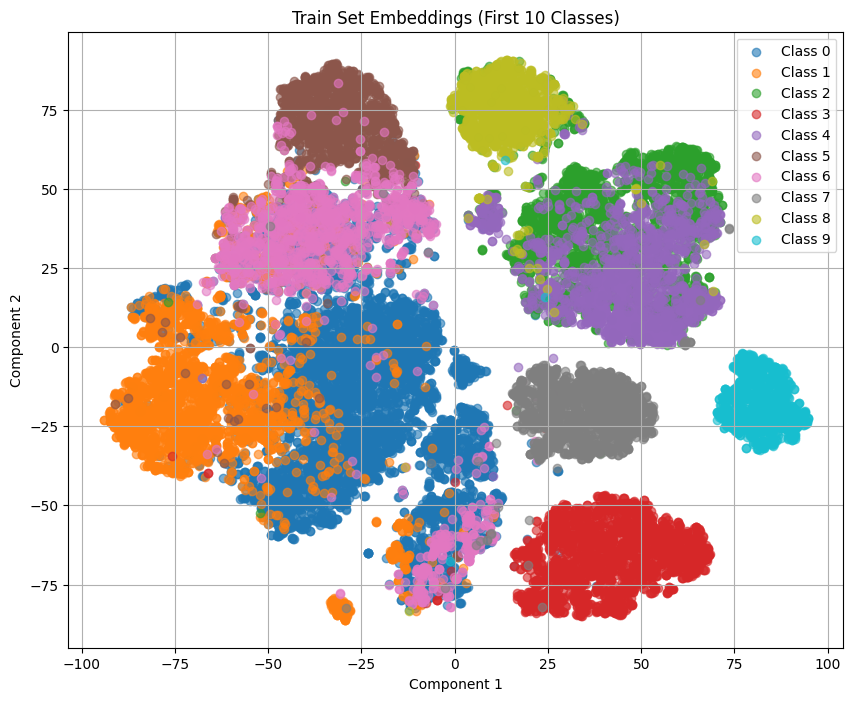

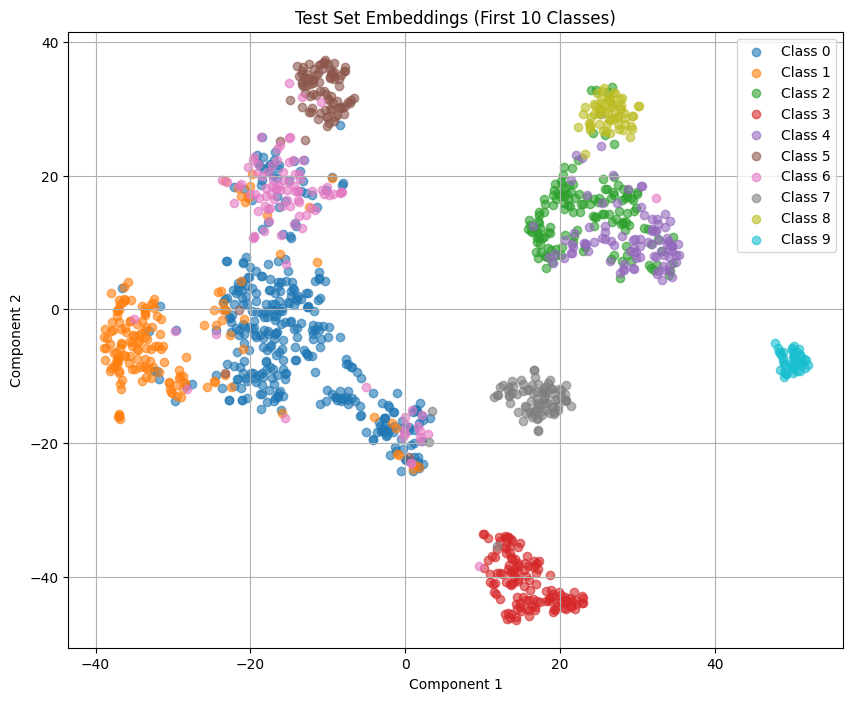

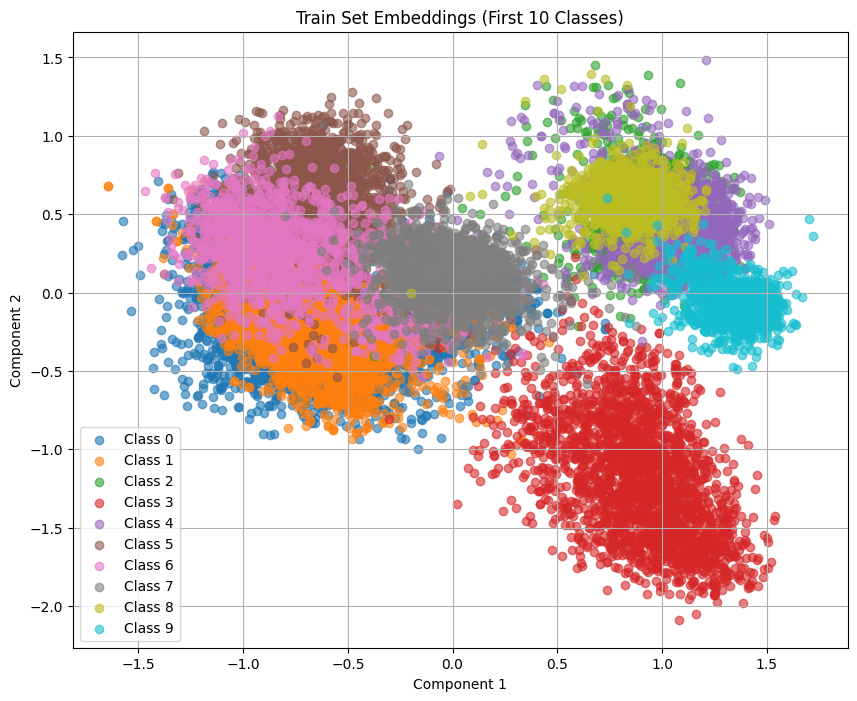

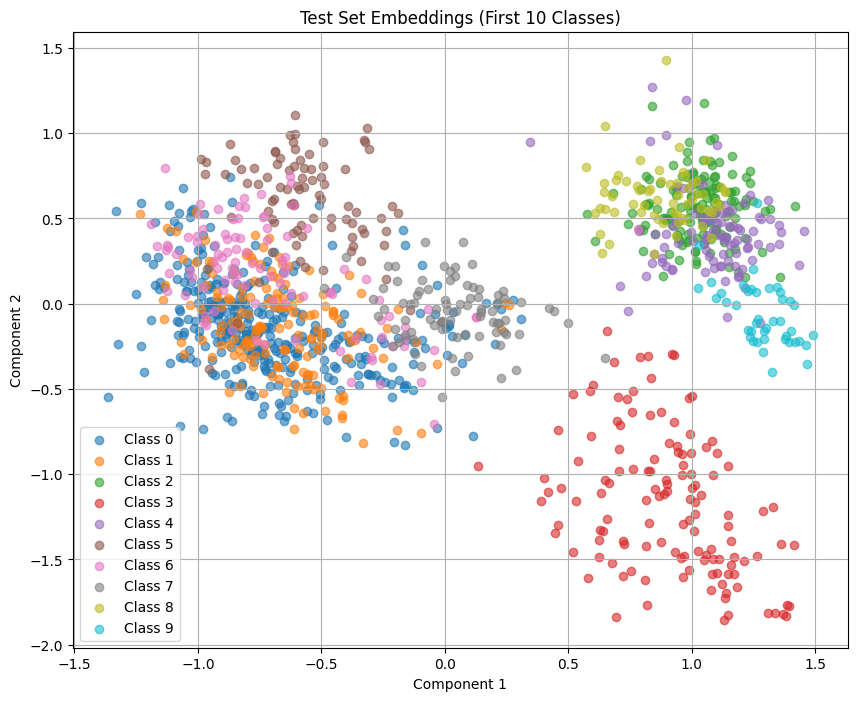

In [179]:
import matplotlib.pyplot as plt

def plot_embeddings(reduced_embeddings, labels, title):
    plt.figure(figsize=(10, 8))
    for label in range(10):
        idx = labels == label
        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f'Class {label}', alpha=0.6)
    plt.legend()
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

'----------------------------------TSNE----------------------------------'

plot_embeddings(reduced_train_2d, 
                labels_train_10.numpy(), 
                title='Train Set Embeddings (First 10 Classes)')

plot_embeddings(reduced_test_2d, 
                labels_test_10.numpy(), 
                title='Test Set Embeddings (First 10 Classes)')

'----------------------------------PCA----------------------------------'

plot_embeddings(reduced_train_2d_pca, 
                labels_train_10.numpy(), 
                title='Train Set Embeddings (First 10 Classes)')

plot_embeddings(reduced_test_2d_pca, 
                labels_test_10.numpy(), 
                title='Test Set Embeddings (First 10 Classes)')

## Step 2

In [180]:
train_mask, embeddings_train_10, labels_train_10, images_train_10 = filter_first_n_classes(embeddings2, labels2, images2, n_classes_to_plot)

_, support_embeddings_10, support_labels_10, _ = filter_first_n_classes(embeddings4, labels4, img_ids4, 10)
_, test_embeddings_10, test_labels_10, _ = filter_first_n_classes(embeddings3, labels3, img_ids3, 10)

In [181]:

knn_10 = KNeighborsClassifier(n_neighbors=1)
knn_10.fit(support_embeddings_10, support_labels_10)
preds_10 = knn_10.predict(test_embeddings_10)

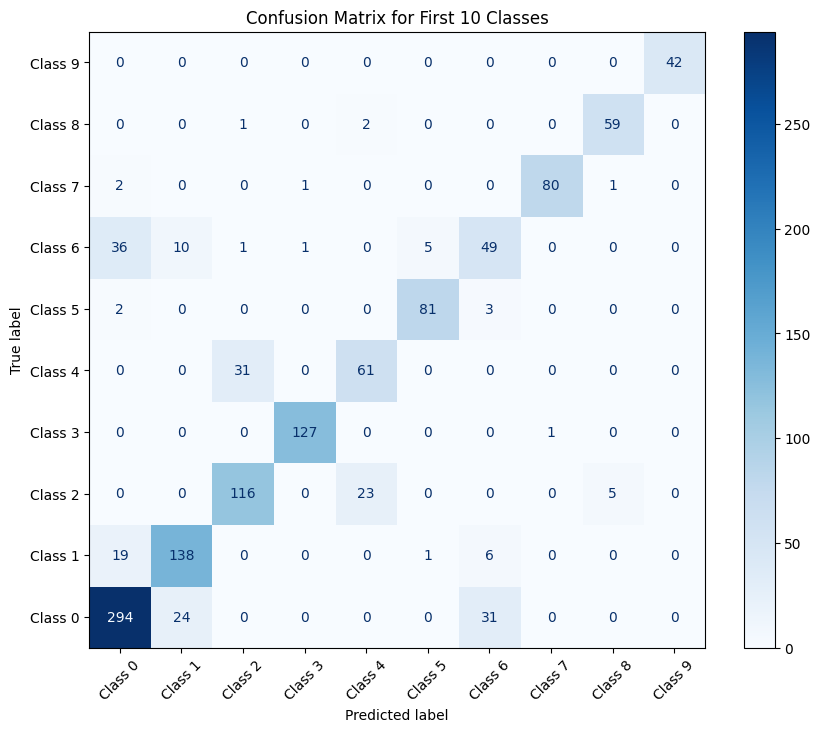

In [182]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels_10, preds_10, labels=list(range(10)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(10)])

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for First 10 Classes")
plt.grid(False)
plt.gca().invert_yaxis()
plt.show()

## Step 3

In [ ]:
from torch.utils.data import Subset

def print_sample_info(dataset, index):
    img, label = dataset[index]
    article_type_name = dataset.df.iloc[index]["articleTypeName"]
    print(f"Sample {index}: {article_type_name} ({label.item()})")
    if True:
        plt.imshow(img.permute(1, 2, 0)) 
        plt.axis("off")
        plt.show()

def identify_class(label_id):
    if label_id in label_id_to_label_name:
        return label_id_to_label_name[label_id]
    else:
        return "Unknown Class"

def identify_class_by_name(name):
    for label_id, label_name in label_id_to_label_name.items():
        if label_name == name:
            return label_id
    return -1 

tshirt_class = identify_class_by_name("Tshirts")
shirt_class = identify_class_by_name("Shirts")

test_tshirt_embeddings = embeddings_test_10[labels_test_10 == tshirt_class]
test_shirt_embeddings = embeddings_test_10[labels_test_10 == shirt_class]
train_tshirt_embeddings = embeddings_train_10[labels_train_10 == tshirt_class]
train_shirt_embeddings = embeddings_train_10[labels_train_10 == shirt_class]


test_centroids = {
    "Tshirts": test_tshirt_embeddings.mean(axis=0),
    "Shirts": test_shirt_embeddings.mean(axis=0)
}

train_centroids = {
    "Tshirts": train_tshirt_embeddings.mean(axis=0),
    "Shirts": train_shirt_embeddings.mean(axis=0)
}


def closest_to_centroid(embeddings, labels, class_id, centroid):
    class_indices = np.where(labels == class_id)[0]
    class_embs = embeddings[class_indices]
    dists = np.linalg.norm(class_embs - centroid, axis=1)
    closest_idx = class_indices[np.argmin(dists)]
    return closest_idx  # index in dataset

idx_tshirt = closest_to_centroid(embeddings2, labels2, 0, train_centroids["Tshirts"])
idx_shirt = closest_to_centroid(embeddings2, labels2, 1, train_centroids["Shirts"])

def show_image_by_index(dataset, idx, title=""):
    image, label = dataset[idx]
    plt.imshow(image.permute(1, 2, 0) * 0.5 + 0.5)  # unnormalize
    plt.title(title)
    plt.axis("off")
    plt.show()

show_image_by_index(train_dataset, idx_tshirt, title="Closest to T-shirt Centroid")
show_image_by_index(train_dataset, idx_shirt, title="Closest to Shirt Centroid")


idx_tshirt_test = closest_to_centroid(embeddings1, labels1, 0, train_centroids["Tshirts"])
idx_shirt_test = closest_to_centroid(embeddings1, labels1, 1, train_centroids["Shirts"])
'''show_image_by_index(main_test_dataset, idx_tshirt_test, title="Closest T-shirt in Test Set")
show_image_by_index(main_test_dataset, idx_shirt_test, title="Closest Shirt in Test Set")
'''

vector = train_centroids["Shirts"] - train_centroids["Tshirts"]
unit_vector = vector / np.linalg.norm(vector)

# Project all embeddings onto the centroid vector
projections = np.dot(embeddings2 - train_centroids["Tshirts"], unit_vector)

# Get indices of only class 0 and 1
mask_0_1 = (labels2 == 0) | (labels2 == 1)
proj_subset = projections[mask_0_1]
indices_subset = np.where(mask_0_1)[0]

# Sort by projection to show transition
sorted_indices = indices_subset[np.argsort(proj_subset)]

# # Visualize 10 images along this path
# for i in np.linspace(0, len(sorted_indices) - 1, 10, dtype=int):
#     show_image_by_index(train_dataset, sorted_indices[i],
#                         title=f"Projection {i+1}")

###In Test Set###
# Step 1: Compute Centroids in the Test Set

# Step 2: Compute Projection Vector & Filter Labels
# Vector from T-shirt to Shirt in test space
vector_test = test_centroids["Shirts"] - test_centroids["Tshirts"]
unit_vector_test = vector_test / np.linalg.norm(vector_test)

# Project all test embeddings onto the T-shirt→Shirt vector
projections_test = np.dot(embeddings1 - test_centroids["Tshirts"], unit_vector_test)

# Get indices of only class 0 and 1 (T-shirt and Shirt)
mask_0_1_test = (labels1 == 0) | (labels1 == 1)
proj_subset_test = projections_test[mask_0_1_test]
indices_subset_test = np.where(mask_0_1_test)[0]

# Sort the indices based on their projection to visualize transition
sorted_indices_test = indices_subset_test[np.argsort(proj_subset_test)]

# # Step 3: Visualize the Transition
# for i in np.linspace(0, len(sorted_indices_test) - 1, 10, dtype=int):
#     show_image_by_index(main_test_dataset, sorted_indices_test[i],
#                         title=f"Projection (Test) {i+1}")




In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def select_transition_indices(dataset, indices, projections, n0=6, n1=4):
    # 1) pull out labels for all candidate indices
    labels = np.array([dataset[i][1] for i in indices])
    
    # 2) split into class-0 and class-1 pools
    mask0 = labels == 0
    mask1 = labels == 1
    
    idx0, proj0 = np.array(indices)[mask0], projections[mask0]
    idx1, proj1 = np.array(indices)[mask1], projections[mask1]
    
    # 3) sort each pool by projection
    sorted0 = idx0[np.argsort(proj0)]
    sorted1 = idx1[np.argsort(proj1)]
    
    # 4) pick n0 evenly-spaced from the T-shirt pool, n1 from the Shirt pool
    sel0 = [sorted0[i] for i in np.linspace(0, len(sorted0)-1, n0, dtype=int)]
    sel1 = [sorted1[i] for i in np.linspace(0, len(sorted1)-1, n1, dtype=int)]
    
    # 5) concatenate so that all 0’s come first, then all 1’s
    return sel0 + sel1

# Recompute your selections:
train_selection = select_transition_indices(
    train_dataset,
    indices_subset,
    proj_subset,
    n0=6,   # 6 T-shirts
    n1=4    # 4 Shirts
)

test_selection = select_transition_indices(
    main_test_dataset,
    indices_subset_test,
    proj_subset_test,
    n0=6,
    n1=4
)

def plot_side_by_side_transition_named(train_dataset, test_dataset, train_indices, test_indices, label_map):
    fig, axes = plt.subplots(len(train_indices), 2, figsize=(5, len(train_indices) * 2))
    for i, (tidx, sidx) in enumerate(zip(train_indices, test_indices)):
        img_t, lbl_t = train_dataset[tidx]
        img_s, lbl_s = test_dataset[sidx]

        # unnormalize (assuming mean=0.5, std=0.5)
        img_t = img_t.permute(1,2,0) * 0.5 + 0.5
        img_s = img_s.permute(1,2,0) * 0.5 + 0.5

        axes[i,0].imshow(img_t); axes[i,0].axis('off');  axes[i,0].set_title('Train')
        axes[i,1].imshow(img_s); axes[i,1].axis('off');  axes[i,1].set_title('Test')

        axes[i,0].text(0.5, -0.15, f"Label: {label_map[lbl_t]}",
                       size=10, ha='center', transform=axes[i,0].transAxes)
        axes[i,1].text(0.5, -0.15, f"Label: {label_map[lbl_s]}",
                       size=10, ha='center', transform=axes[i,1].transAxes)

    plt.suptitle("Smooth Transition: T-shirt → Shirt", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

label_map = {0: "T-shirt", 1: "Shirt"}
plot_side_by_side_transition_named(train_dataset, main_test_dataset, train_selection, test_selection, label_map)


## Step 4

In [163]:
test_embeddings, test_label, test_img_ids = extract_embeddings(model, triplets_test_cat_dataset)
supp_embeddings, supp_labels, supp_img_ids = extract_embeddings(model, triplets_supp_cat_dataset)

accuracy, balance_acc = evaluate_scenario(test_embeddings, test_label, supp_embeddings, supp_labels)
print(f"Scenario 1 - Main Test Set with Main Support Set Accuracy: {accuracy:.4f}")
print(f"Scenario 1 - Main Test Set with Main Support Set Accuracy: {balance_acc:.4f}")


Scenario 1 - Main Test Set with Main Support Set Accuracy: 0.8616
Scenario 1 - Main Test Set with Main Support Set Accuracy: 0.8616
